# Imports & setup

In [1]:
%load_ext autoreload
%autoreload 2

from utils import *
from models import *
import torch
from torch import nn
from torchvision import datasets
import matplotlib.pyplot as plt
from torchvision.transforms import transforms
from torch import nn
from sklearn.model_selection import train_test_split
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import cv2
import numpy as np

In [2]:
image_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Test 

In [3]:
model_crop = LeNet().to(device)
model_crop.load_state_dict(torch.load("./model_retrain_crop"))
model_crop.eval()

LeNet(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=46656, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=8, bias=True)
)

In [4]:
model_basic = LeNet().to(device)
model_basic.load_state_dict(torch.load("./model_retrain"))
model_basic.eval()

LeNet(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=46656, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=8, bias=True)
)

In [5]:
path_pair_img = '../data/photoshoptest_handmade_test'
dataset = datasets.ImageFolder(root=path_pair_img, transform=None)

# We don t use a dataloader because we need to have access to the images to find the cropped
# subimages to give as an input for the ccropped model

In [6]:
# Didn t want to put this in model.py like the other test because we need to change the
# data at the same time and seemed too much of a drag to do ;_; 

y_true = [0, 1]
y_score = [[1, 0, 0, 0, 0, 0, 0, 0], [0, 1, 0, 0, 0, 0, 0, 0]]

for img, y in dataset : 
    
    img_org, img_edt = np.hsplit(np.array(img), 2)

    final_imgs = get_bb(img_org, img_edt)
    
    class_small_bb = [0, 0, 0, 0, 0, 0, 0, 0]

    for final_img in final_imgs : 
        image_tensor = image_transform(Image.fromarray(final_img)).unsqueeze(0)
        image_tensor = image_tensor.cuda()

        with torch.no_grad() : 
            output = model_crop(image_tensor)
        _, predicted_class_crop = torch.max(output, 1)
        class_small_bb[predicted_class_crop] += 1
    
    predicted_class_crop = np.argmax(class_small_bb)

    image_tensor = image_transform(img).unsqueeze(0)
    image_tensor = image_tensor.cuda()
    with torch.no_grad() : 
        score_basic = model_basic(image_tensor)
    _, predicted_class = torch.max(score_basic, 1)

    if (predicted_class_crop == predicted_class) : 
        y_true.append(y)
        
        #Calculate the score based on the two models output : 
        #Methode 1 : 
            #Change the vote array into a proba distribution 
            #Normalize the output of model_basic
            #Add the two distribution and normalize again
        class_small_bb = np.array(class_small_bb)
        score_crop_m = class_small_bb / class_small_bb.sum()
        score_basic_m = nnf.softmax(score_basic, dim=1)[0].cpu().numpy()
        score_final = score_crop_m + score_basic_m
        score_final = score_final / score_final.sum()
        y_score.append(list(score_final))

In [7]:
performance = get_performance(y_true, y_score)

In [8]:
#output : 
#   [accuracy, 
#   f1, 
#   precision, 
#   recall, 
#   roc_auc, 
#   conf_mat, 
#   fp, 
#   fn, 
#   tp, 
#   tn]
performance

[0.6557377049180327,
 0.6557377049180327,
 0.6557377049180327,
 0.6557377049180327,
 0.879431393769629,
 array([[ 1,  0,  0,  0,  0,  0,  0,  0],
        [ 0,  2,  0,  0,  0,  0,  0,  0],
        [ 0,  0, 17,  0,  0,  0,  0,  0],
        [ 0,  0,  0,  4,  0,  0,  0,  1],
        [ 0,  0,  0,  1, 12,  0,  0,  3],
        [ 0,  0,  1,  2,  0,  0,  1,  1],
        [ 0,  0,  0,  0,  0,  0,  0, 10],
        [ 0,  0,  0,  1,  0,  0,  0,  4]], dtype=int64),
 array([ 0,  0,  1,  4,  0,  0,  1, 15], dtype=int64),
 array([ 0,  0,  0,  1,  4,  5, 10,  1], dtype=int64),
 array([ 1,  2, 17,  4, 12,  0,  0,  4], dtype=int64),
 array([60, 59, 43, 52, 45, 56, 50, 41], dtype=int64)]

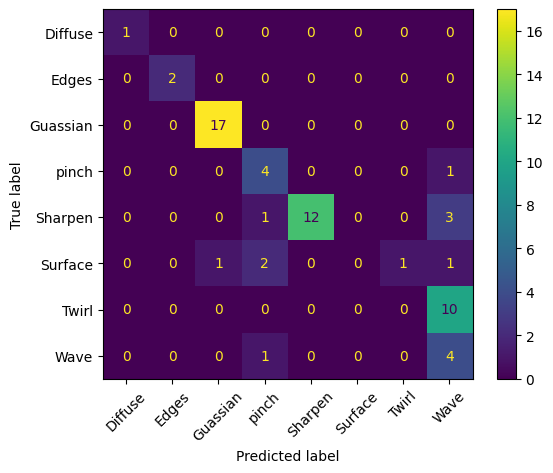

In [9]:
conf_matrix = performance[5]
labels = ["Diffuse", "Edges", "Guassian", "pinch", "Sharpen", "Surface", "Twirl", "Wave"]
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels = labels)
disp.plot()
plt.xticks(rotation = 45) 
plt.show()